Written by Joao Rodrigues

June 2020

Example: Implements a simple, spatially resolved, 2D harmonic oscillator and calculates the steady-state populations and a function of increasing pump power. The idea is to show the occurence of BEC phase transition, and eventually other phase transitions.

Note: All parameters are defined in SI units


In [2]:
import numpy as np
import scipy.constants as sc
import matplotlib.pyplot as plt
import os
import sys
sys.path.insert(0, os.path.abspath('..'))

## Calculates the cavity modes for a spherical mirror

In [3]:
grid_size = 12.0*1e-6      # meters
grid_delta = 0.5*1e-6      # meters 
L0 = 2.0*1e-6              # meters 
q = 10                     # longitudinal mode number
n = 1.43
n_modes = 50
feature_RoC = 250.0*1e-6   # meters
feature_depth = 0.279*1e-6 # meters

from PyPBEC.Cavity import Modes
cavity_modes = Modes(grid_size=grid_size, grid_delta=grid_delta, L0=L0, q=q, n=n, n_modes=n_modes)
cavity_modes.set_geometry_spherical(RoC=feature_RoC, depth=feature_depth)
lambdas, modes = cavity_modes.compute_cavity_modes()
g = cavity_modes.get_coupling_matrix()

## Defines the cavity pump profile

In [4]:
pump_width = 2.5*1e-6       # meters

X, Y = cavity_modes.get_cavity_grid()
pump_base = np.exp(-((X)**2+Y**2) / pump_width**2)
pump = 1*(pump_base/np.sum(pump_base))
cavity_modes.load_pump(pump=pump)

## Plots the cavity modes and the pump profile

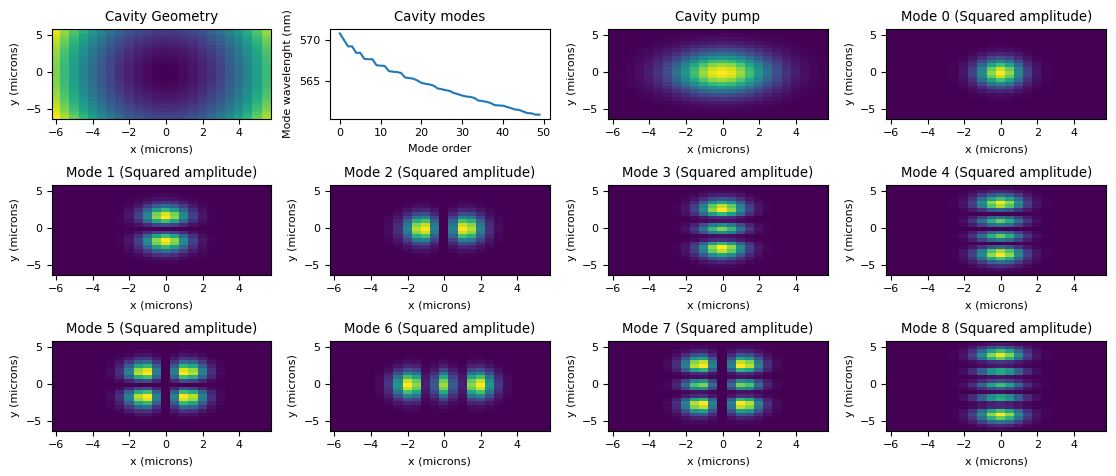

In [5]:
cavity_modes.plot_cavity()


## Calculates emission and absorption rates from experimental data

In [6]:
dye_concentration = 2.0               # in mM, with 1 mM=1mol/m^3

from PyPBEC.OpticalMedium import OpticalMedium
R6G = OpticalMedium(optical_medium="Rhodamine6G")
absorption_rates, emission_rates = R6G.get_rates(lambdas=lambdas, dye_concentration=dye_concentration, n=n)
print(absorption_rates)

[9.17574079e+10 1.06178362e+11 1.21507571e+11 1.21737621e+11
 1.40433385e+11 1.40466888e+11 1.60421159e+11 1.61756423e+11
 1.61802897e+11 1.82645693e+11 1.83694869e+11 1.84720260e+11
 2.05619215e+11 2.08975186e+11 2.10535300e+11 2.15062414e+11
 2.38369347e+11 2.41268964e+11 2.43976139e+11 2.52803767e+11
 2.65908724e+11 2.71706980e+11 2.74986151e+11 2.81168458e+11
 2.98753086e+11 3.03586845e+11 3.09119649e+11 3.14666290e+11
 3.27678464e+11 3.34793058e+11 3.44343610e+11 3.51090096e+11
 3.53860910e+11 3.61364411e+11 3.80392389e+11 3.84223000e+11
 3.90522679e+11 4.00554842e+11 4.17770704e+11 4.19768691e+11
 4.22110312e+11 4.32208344e+11 4.43122079e+11 4.55328846e+11
 4.59840720e+11 4.74446126e+11 4.90125014e+11 4.92139404e+11
 5.04509790e+11 5.04662858e+11]


#### Normalizes the rates, for better numerical performance

In [7]:
cavity_loss_rate = 1.0/(10*1e-12)     # in s^-1

cavity_loss_rates = np.ones(n_modes)
emission_rates = emission_rates / cavity_loss_rate
absorption_rates = absorption_rates / cavity_loss_rate

## Defines a cavity

In [8]:
Gamma_down = 100.0

# Properties of the photonic modes
from PyPBEC.Cavity import Cavity
cavity = Cavity(M=n_modes, J=g.shape[1])
cavity.set_cavity_loss_rates(rates=cavity_loss_rates)
cavity.set_cavity_emission_rates(rates=emission_rates)
cavity.set_cavity_absorption_rates(rates=absorption_rates)

# Properties of the molecular modes
cavity.set_reservoir_decay_rates(rates=Gamma_down*np.ones(g.shape[1]))
cavity.set_reservoir_pump_rates(rates=np.reshape(pump, [pump.shape[0]*pump.shape[1]]))
molecular_population = np.array(sc.Avogadro*dye_concentration*(0.5*L0*grid_delta**2)*np.ones(g.shape[1]), dtype=int)
cavity.set_reservoir_population(population=molecular_population)

# Coupling between photonic and molecular modes
cavity.set_coupling_terms(coupling_terms=g)


## Creates the array of pump values

In [9]:
pump_value_min = 100.0
pump_value_max = 1000000.0
n_pump_values = 40

delta_p = (pump_value_max/pump_value_min)**(1/n_pump_values)-1
pumps = [(1+delta_p)**i*pump_value_min for i in range(0, n_pump_values)]

## Solves the mean-field steady-state

In [10]:
from PyPBEC.Solver import SteadyState
from tqdm import tqdm
populations = list()
for value in tqdm(pumps):
    # loads the pump onto the cavity object
    pump = value*(pump_base/np.sum(pump_base))
    cavity.set_reservoir_pump_rates(rates=np.reshape(pump, [pump.shape[0]*pump.shape[1]]))
    
    # Steady-state solver
    solver_steadystate = SteadyState(cavity_obj=cavity, ANNEALING=False)
    # Defines the initial guess
    if value==pumps[0]:
        solver_steadystate.set_initial_photons(initial_photons=np.array(np.zeros(cavity.M)))
        solver_steadystate.set_initial_excited_molecules(initial_excited_molecules=np.array(np.zeros(cavity.J)))  
    else:
        solver_steadystate.set_initial_photons(initial_photons=np.array(solved_cavity_steadystate.photons[-1]))
        solver_steadystate.set_initial_excited_molecules(initial_excited_molecules=np.array(solved_cavity_steadystate.emols[-1])) 
    
    # Calls the solver
    solved_cavity_steadystate = solver_steadystate.solve()
    
    # Sums the populations over the mode degeneracy, g=n+1, with n=0,1,2,...
    mode_degeneracy = np.array([j for j in range(0, n_modes) for i in range(0, j)][0:n_modes])
    steady_state_photon_population = [np.sum(solved_cavity_steadystate.photons[:,np.where(mode_degeneracy==mode_number)[0]], 1) 
        for mode_number in list(set(list(mode_degeneracy)))]
    steady_state_photon_population = np.transpose(np.array(steady_state_photon_population))
    
    # Appends
    populations.append(steady_state_photon_population)
populations = np.array(populations)

100%|██████████| 40/40 [03:50<00:00,  5.76s/it]


## Plots the results

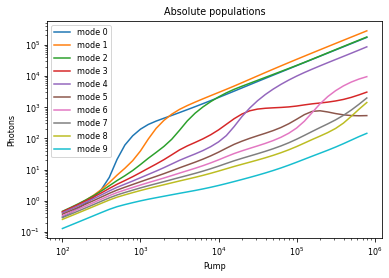

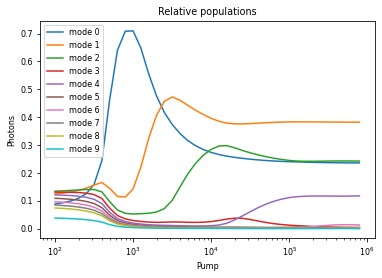

In [10]:
populations = np.squeeze(populations)

[plt.plot(pumps, populations[:,i], label="mode {0}".format(i)) for i in range(0, populations.shape[1])]
plt.legend()
plt.xlabel("Pump")
plt.xscale("log")
plt.ylabel("Photons")
plt.yscale("log")
plt.title("Absolute populations")
plt.show()

[plt.plot(pumps, populations[:,i]/np.sum(populations,1), label="mode {0}".format(i)) for i in range(0, populations.shape[1])]
plt.legend()
plt.xlabel("Pump")
plt.xscale("log")
plt.ylabel("Photons")
plt.title("Relative populations")
plt.show()